In [77]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection    import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model       import LogisticRegression
from sklearn.metrics            import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve


df = pd.read_csv("spam_and_ham_classification.csv")

print(df.shape)            # e.g., (some_number_of_rows, 3)
print(df.columns)          # Expecting columns such as ['label', 'text', ...]
print(df.head(5))          # Preview the first few rows
print(df["label"].value_counts())  # Confirm it’s balanced: equal counts of 'spam' and 'ham'


(9989, 2)
Index(['label', 'text'], dtype='object')
  label                                               text
0   ham  into the kingdom of god and those that are ent...
1  spam  there was flow at hpl meter 1505 on april firs...
2   ham  take a look at this one campaign for bvyhprice...
3  spam  somu wrote actually thats what i was looking f...
4  spam  fathi boudra wrote i fixed the issue in the sv...
label
ham     5294
spam    4695
Name: count, dtype: int64


In [39]:
# Text Cleaning
def clean_text(text):
    # 1. Convert to lowercase
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r"http\S+", "", text)
    # 3. Remove non-alphanumeric characters (keep spaces)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    # 4. Collapse multiple spaces into one
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply the cleaning function to the entire DataFrame
df["clean_text"] = df["text"].apply(clean_text)

# Quick check of the new column
df[["clean_text", "label"]].head()


,clean_text,label
0,into the kingdom of god and those that are ent...,ham
1,there was flow at hpl meter 1505 on april firs...,spam
2,take a look at this one campaign for bvyhprice...,ham
3,somu wrote actually thats what i was looking f...,spam
4,fathi boudra wrote i fixed the issue in the sv...,spam


In [41]:
# Stratified Split
# First split: 80% train, 20% temp (val + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df["label"],
    random_state=13
)

# Second split: 10% validation, 10% test (each 50% of temp_df)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=13
)

# Confirm shapes and label distributions
print("Train shape:", train_df.shape)
print(train_df["label"].value_counts(normalize=True))
print("Validation shape:", val_df.shape)
print(val_df["label"].value_counts(normalize=True))
print("Test shape:", test_df.shape)
print(test_df["label"].value_counts(normalize=True))


Train shape: (7991, 3)
label
ham     0.529971
spam    0.470029
Name: proportion, dtype: float64
Validation shape: (999, 3)
label
ham     0.52953
spam    0.47047
Name: proportion, dtype: float64
Test shape: (999, 3)
label
ham     0.530531
spam    0.469469
Name: proportion, dtype: float64


In [43]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2)
)

# Fit on the training set, then transform all three
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_val   = vectorizer.transform(val_df["clean_text"])
X_test  = vectorizer.transform(test_df["clean_text"])

# Encode labels as binary (ham=0, spam=1)
y_train = train_df["label"].map({"ham": 0, "spam": 1}).values
y_val   = val_df["label"].map({"ham": 0, "spam": 1}).values
y_test  = test_df["label"].map({"ham": 0, "spam": 1}).values

# Print shapes to confirm
print("X_train shape:", X_train.shape)
print("X_val shape:  ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train length:", len(y_train))
print("y_val length:  ", len(y_val))
print("y_test length: ", len(y_test))


X_train shape: (7991, 105579)
X_val shape:   (999, 105579)
X_test shape:  (999, 105579)
y_train length: 7991
y_val length:   999
y_test length:  999


In [44]:
# Baseline Model: Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_val_pred = lr.predict(X_val)
acc  = accuracy_score(y_val, y_val_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average="binary", pos_label=1
)

print(f"Validation Accuracy: {acc:.4f}")
print(f"Spam Precision : {prec:.4f}")
print(f"Spam Recall    : {rec:.4f}")
print(f"Spam F1-score  : {f1:.4f}")


Validation Accuracy: 0.9710
Spam Precision : 0.9825
Spam Recall    : 0.9553
Spam F1-score  : 0.9687


 ## Confusion Matrix Visualization 

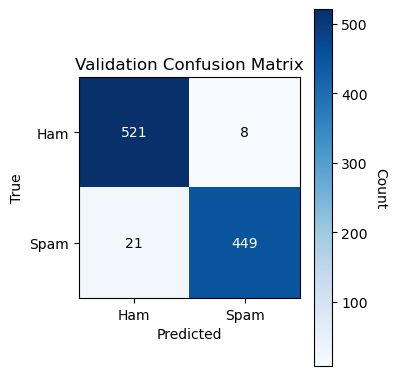

In [33]:
# %% [markdown]
# ## Confusion Matrix Visualization 

# %% 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix (using your existing y_val and y_val_pred)
cm = confusion_matrix(y_val, y_val_pred)
labels = ['Ham', 'Spam']

# Plot with a blue color gradient
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.set_title('Validation Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Add colorbar for reference
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Count', rotation=-90, va="bottom")

# Tick marks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Annotate cells with counts, text color based on background brightness
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()



## Hyperparameter Tuning (Linear SVM)


In [57]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# 1. Try different values of C (regularization strength)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# 2. Set up grid search to optimize F1-score on spam class, using 5-fold CV
grid_svm = GridSearchCV(
    estimator=LinearSVC(random_state=42, max_iter=10000),
    param_grid=param_grid,
    scoring='f1',  
    cv=5,
    n_jobs=-1
)

# 3. Run the grid search on the training data
grid_svm.fit(X_train, y_train)

# 4. Display the best C value and its CV F1-score
print("Best C found:", grid_svm.best_params_['C'])
print("Best cross-val F1:", grid_svm.best_score_.round(4))

# 5. Save the tuned model for later evaluation
tuned_svm = grid_svm.best_estimator_


Best C found: 10
Best cross-val F1: 0.9797


Validation Results (C=10):
  Accuracy : 0.9870
  Precision: 0.9957
  Recall   : 0.9766
  F1-score : 0.9860


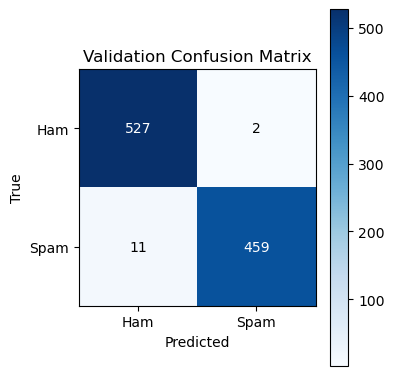

In [59]:
# Validation-Set Evaluation of Tuned SVM

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt

# Predict on validation data
y_val_pred_tuned = tuned_svm.predict(X_val)

# Compute metrics
acc_v, prec_v, rec_v, f1_v = (
    accuracy_score(y_val, y_val_pred_tuned),
    *precision_recall_fscore_support(y_val, y_val_pred_tuned, average='binary', pos_label=1)[:3]
)
print(f"Validation Results (C={tuned_svm.C}):")
print(f"  Accuracy : {acc_v:.4f}")
print(f"  Precision: {prec_v:.4f}")
print(f"  Recall   : {rec_v:.4f}")
print(f"  F1-score : {f1_v:.4f}")

# Plot confusion matrix
cm_v = confusion_matrix(y_val, y_val_pred_tuned)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm_v, cmap='Blues')
ax.set_title('Validation Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Ham','Spam'])
ax.set_yticklabels(['Ham','Spam'])
thresh = cm_v.max()/2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_v[i,j],
                ha='center', va='center',
                color='white' if cm_v[i,j]>thresh else 'black')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


Test Results:
  Accuracy : 0.9800
  Precision: 0.9870
  Recall   : 0.9701
  F1-score : 0.9785


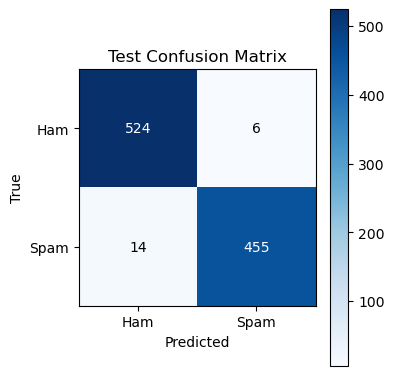

In [63]:
##  Final Test-Set Evaluation

import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)

# 1. Predict on test data
y_test_pred = tuned_svm.predict(X_test)

# 2. Compute final metrics
acc_t, prec_t, rec_t, f1_t = (
    accuracy_score(y_test, y_test_pred),
    *precision_recall_fscore_support(
         y_test, y_test_pred, average='binary', pos_label=1
      )[:3]
)

print("Test Results:")
print(f"  Accuracy : {acc_t:.4f}")
print(f"  Precision: {prec_t:.4f}")
print(f"  Recall   : {rec_t:.4f}")
print(f"  F1-score : {f1_t:.4f}")

# 3. Plot test confusion matrix
cm_t = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm_t, cmap='Blues')
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Ham','Spam'])
ax.set_yticklabels(['Ham','Spam'])
thresh = cm_t.max() / 2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_t[i, j],
                ha='center', va='center',
                color='white' if cm_t[i, j] > thresh else 'black')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()



### Ablation Study: TF–IDF Configurations

In [69]:


configs = [
    ("Unigram Only",       (1,1), 3, 0.85),
    ("Unigram + Bigram",   (1,2), 3, 0.85),
    ("Strict Filtering",   (1,2), 5, 0.80),
]

rows = []
for name, ngram_range, min_df, max_df in configs:
    vect = TfidfVectorizer(ngram_range=ngram_range,
                           min_df=min_df,
                           max_df=max_df)
    X_tr = vect.fit_transform(train_df["clean_text"])
    X_vl = vect.transform(val_df["clean_text"])
    svm = LinearSVC(C=tuned_svm.C, random_state=42, max_iter=5000)
    svm.fit(X_tr, y_train)
    preds = svm.predict(X_vl)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_val, preds, average="binary", pos_label=1
    )
    rows.append((name, prec, rec, f1))

ablation_df = pd.DataFrame(rows, columns=["Config","Precision","Recall","F1-score"])
ablation_df


,Config,Precision,Recall,F1-score
0,Unigram Only,0.991453,0.987234,0.989339
1,Unigram + Bigram,0.995662,0.976596,0.986037
2,Strict Filtering,0.995662,0.976596,0.986037


### Learning Curve: Tuned SVM Performance vs. Training Size


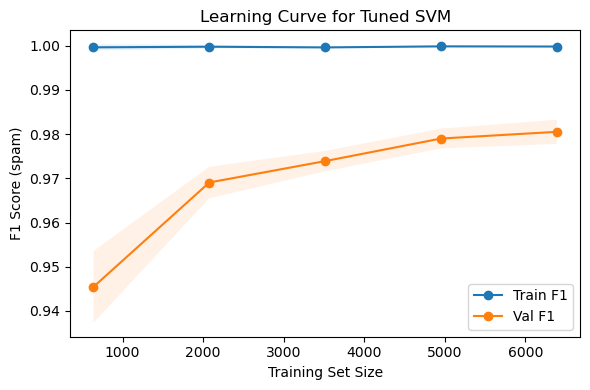

In [98]:
pipeline = Pipeline([
    ("vect", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.85)),
    ("clf", LinearSVC(C=tuned_svm.C, random_state=42, max_iter=5000))
])

train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline,
    X=train_df["clean_text"],
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5,
    scoring="f1",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, 'o-', label="Train F1")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, 'o-', label="Val F1")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score (spam)")
plt.title("Learning Curve for Tuned SVM")
plt.legend()
plt.tight_layout()
plt.show()
